### Still plugging away... 

It's time to get to (prepping for) audio

In [1]:
# Just your usual setup

import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fdls
import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  For CPU use 16K appears best.
blocklenk = 16
blocklen = (blocklenk * 1024)

# hilbert_filter_terms has a direct impact on filter delays
hilbert_filter_terms = 1024
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
blockcut = hilbert_filter_terms + 192

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

# TODO: merge with below
def doplot(B, A, freq = 40, extra = None, whole = False):
    w, h = sps.freqz(B, A, whole = whole)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    db = 20 * np.log10(abs(h))
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    


In [5]:
#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

In [6]:
# Load up default parameters

params = {'freq': 40, 'blocklen': blocklen}

for p in [SysParams_NTSC]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]
        
params['MTF'] = sps.zpk2tf(.1, -.5, 1.65)
params['MTF'] = sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)

In [7]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [8]:
hz0ire = params['videorf_0ire']

In [9]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [10]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [11]:
# This filter (attempts to) compensate for phase distortion from the 2-pole elliptical filter
# on the DD 3.0 board.  It still needs some development work, but a little phase adjustment
# goes a long way to improve colors
def calculate_dd_filter(params):
    filterdata = pd.read_csv('dd30phase.csv').iloc[:]
    # add an ending to try to keep freq response closer to even
    filterdata.loc[65] = [20000000, 144]

    ffreq = (filterdata.hz / (params['freq_hz'] / 2)) * np.pi

    fphase = (filterdata.phase) * (np.pi / 180)
    flevela = np.ones_like(fphase)

    fphase[58:] += (np.pi* 2)

    cut = 0
    cutend = len(ffreq)-0
    _level = 1
    _shift = -.02
    dimb = 1
    dima = 3
    [fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)

    return fb, fa



In [12]:
# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    blocklen = params['blocklen']
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'), blocklen)
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    #tmp = filtfft([fb, fa], blocklen)
    #SP['FRFVideo'] *= tmp
    
    #SP['FRFVideo'] *= exp
    
    SP['Fhilbert'] = np.fft.fft(hilbert_filter, blocklen)
    
    SP['Fdd'] = filtfft(calculate_dd_filter(SP), blocklen)
    
    # This MTF filter needs A LOT of work!
    #[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.65)
    SP['Fmtf'] = filtfft(SP['MTF'], blocklen)
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'), blocklen) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low'), blocklen) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = int(np.ceil((18 * freq_half / SP['fsc_mhz']) / 2) * 2)
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
#        print(SP['Fburst_len'])
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]), blocklen)
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f, blocklen)
    
    return SP

In [13]:
# The actual video demodulation code

def dodemod(paramsc, data, mtf_level = 0, dd_level = 1.0, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if mtf_level != 0:
        indata_fft_filt *= paramsc['Fmtf'] ** mtf_level

    if dd_level != 0:
        indata_fft_filt *= paramsc['Fdd'] ** dd_level
        
        
    hilbert = np.fft.ifft(indata_fft_filt * paramsc['Fhilbert'])

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * paramsc['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, indata_fft_filt, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [14]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9850000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [15]:
# note: currently returns PSNR assuming IRE==100
def calcsnr(a):
    #stdire = np.std(a) / NTSC_hz_ire
    #return(20 * np.log10(100 / stdire))
    
    signal = hztoire(np.mean(a))
    noise = np.std(a) / hz_ire_scale
    #print(signal, noise)
    return 20 * np.log10(70 / noise)


In [16]:
# Scaler code in Python is horribly slow - numpy is a bit less so

# Thankfully for bit unpacking there are numpy routines to operate on bit arrays...
def load_packed_data(infile, sample, readlen = blocklen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [17]:
def loaddata(infile, sample):

    # packed data is a bit more complicated
    if sampletype == 3:
        return load_packed_data(infile, sample)

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata


In [18]:
def demod(infile, _start, _end, filterset, mtf_level = 0.0, dd_level = 1.0, retraw = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    #print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
        if indata is None:
            break
        
        tmp = dodemod(filterset, indata, mtf_level, dd_level)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    if retraw:
        return output, indata
    else:
        return output
    

In [19]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [20]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [21]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(filterset['blocklen'], dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

In [22]:
def pxtousec(px, freq = 40000000):
    return (px / freq) * 1000000

def usectopx(usec, freq = 40000000):
    return freq * usec / 1000000

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [23]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
#        print(loc)
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
            if (np.argmax(data['demod_sync']) / filterset['line_px']) < 16:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        #print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        #print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and not firstfield:
            return loc + nextline, data
        else:
            loc += int(120 * filterset['line_px'])
    
    return None

In [24]:
# note:  this VBI decoder works with unscaled lines.
def decodephillipscode(data, linestart):
    #print(linestart)
    curzc = calczc(data, int(linestart + usectopx(2)), iretohz(50), int(usectopx(12)))

    zc = []
    while curzc is not None:
        zc.append((curzc, data[int(curzc - usectopx(0.5))] < iretohz(50)))
        curzc = calczc(data, curzc+usectopx(1.9), iretohz(50), int(usectopx(0.2)))

    usecgap = pxtousec(np.diff([z[0] for z in zc]))
    valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

    if valid:
        bitset = [z[1] for z in zc]
        linecode = []
        for b in range(0, 24, 4):
            linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
        #print(bitset)
        #print(linecode)
        return linecode
    else:
        return None
    
def processphillipscode(data, lines):
    rv = {'codes': []}
#    codes = []
    for l in range(6, 10):
        lc = decodephillipscode(data, lines[l])
        if lc is not None:
            rv['codes'].append((l, lc))
            if lc[0] == 15: # frame code
                if lc[2] == 13: # CLV
                    print('CLV')
                    rv['frame'] = -1
                else: # CAV
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    print('CAV frame #', frame)
                    rv['frame'] = frame
                    
    return rv

In [25]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [26]:
def inpicture(linenum):
    if linenum is None:
        return False
    
    return inrange(linenum, 10, 263.4) or inrange(linenum, 273, 525)

#linelocs, end = findsync(frame, 0)

# this needs *a lot* of cleaning up
def cburstalign(frame, lineinfo, badburst, shift33 = -((33.0 / 360.0) * np.pi)):
    lineinfo_tmpa = lineinfo.copy()
    offset = 0
    
    output = frame['demod']
    output_burst = frame['demod_burst']
    
    peak = []
    cuts = []
    for l in range(1, 525):
        if badburst[l]:
            #lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
        
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()
        
        peak.append(np.argmax(np.abs(cut)))
        
    peak = np.array(peak)
    peakmean = peak.mean()
    
    zc = []
    linelens = []
    for l in range(1, 525):
        if badburst[l]:
            continue

        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        #zc.append(calczc(cut, np.floor(peakmean), 0, 5))
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        try:
            zc.append(calczc(cut, np.floor(peakmean), 0, 5) * (outwidth / linelen))
            linelens.append(lineinfo_tmpa[l + 1] - lineinfo_tmpa[l])
        except:
            None
        
    print("zcmean ", np.mean(zc), np.mean(zc) * (outwidth / np.mean(linelens)))
        
    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, 525):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            print('bad burst', l, lineinfo[l], lineinfo2[l], tmp)
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue

        # find the nearest odd # for the peak crossover.
        target = (np.round((adjpeak - 1) / 2) * 2) + 1
        offsets[l] = (adjpeak - target)

        #print('fs ', l, np.argmax(cut), adjpeak, target,  offsets[l], lineinfo2[l], lineinfo_tmpa[l], lineinfo_tmpa[l] - lineinfo_tmpa[l - 1])
            
    if np.mean(np.abs(offsets)) > .8:
        print("WARNING: offsets too high")
            
    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, 524):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 2])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2
            
    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, 525):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    

    return lineinfo_tmpa, lineinfo_cphaseadj, offsets

badburst = np.zeros(526)
#linelocs2, linelocs2_phaseadj, offsets = cburstalign(frame, linelocs, badburst)

In [47]:
# this still needs to be simplified... 

def findsync_getpulses(frame, start, line_px = 2540, lines = 525):
    curloc = start
    ilinepx = int(line_px)
    
    output = frame['demod']
    output_sync = frame['demod_sync']

    lastline = start
    linenum = None
    lineinfo = {}
    
    sstart = 0
    send = int(line_px)
    
    # Check every half-line for equalization pulses
    
    while linenum is None or (linenum <= 526 and ((curloc - lastline) < (lines * line_px))):
        offset = np.argmax(output_sync[curloc + sstart:curloc + send])
        lineloc = curloc + sstart + offset
        
        #lineloc = int(np.round(calczc(frame['demod'], lineloc-300, iretohz(-20), 500)))

        synclevel = output_sync[lineloc]
        

        # the adjustment factor is set per line type - calibrated against an acutal disk
        adjustment = 0
        if inrange(synclevel, 0.65, 0.8) or (inpicture(linenum) and inrange(synclevel, 0.3, 0.85)): # regular line
            # find the zero crossing of the non-filtered demod signal... or interpolate if this is wrong
            try:
                lineloc = int(np.round(calczc(output, lineloc - 10, iretohz(-20), 30)))
            except:
                lineloc = lineinfo[linenum - 1]  + (lineinfo[linenum - 1] - lineinfo[linenum - 2])
                #None

            sstart = int(line_px * .45)
            send = int(line_px * .55)
            
            lastline = lineloc
            # If we're in the middle of a frame, don't scan mid-lines
            if linenum is not None and inpicture(linenum):
                curloc = lineloc + int(line_px * .5)
            else:
                curloc = lineloc
                
        elif inrange(synclevel, 0.4, 0.65): # equalization pulse - before and after vsync
            if not inrange(lineloc - lastline, line_px * .95, line_px * 1.05) and linenum is None:
                return None, curloc + (ilinepx * 250)
            elif linenum is None:
                linenum = 1
            # adjust to match observed color burst timing
            adjustment = int(usectopx(2.4))
            curloc = lineloc
        elif inrange(synclevel, 0.8, 1.01): # vsync
            # VSYNC pulse is active low - I found that using the derivative of the sync LPF works nicely
            demod_sync_diff = np.diff(frame['demod_sync'][int(lineloc)-500:int(lineloc)])
            lineloc = lineloc - 500 + np.argmax(demod_sync_diff)

            # The color burst - if it happens - is about 4.6usec after vsync starts
            adjustment = int(usectopx(4.65))
            curloc += int(line_px * .5)
        else: # probably middle of regular line
            curloc += int(line_px * .5)
            
        if linenum is not None:
            # save integers if not a half-line
            if np.abs(linenum - np.int(linenum)) > .1:
                lineinfo[linenum] = lineloc
                #print(linenum, lineloc)
            else:
                lineinfo[int(linenum)] = lineloc + adjustment
                #print(linenum, lineloc + adjustment)
                
        if linenum is not None:
            if inpicture(linenum):
                linenum += 1.0
            else:
                linenum += 0.5

        
    return lineinfo, lineinfo[520] - (linelen // 2)

In [48]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 525):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

def buildframe(frame, lineliist):
    badburst = np.zeros(526)
    linelist2, lineinfo_cphaseadj, offsets = cburstalign(frame, linelist, badburst)    
    
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstlevel = [None]
    field_cburst, sfactor = downscale_field(frame['demod_burst'][filterset['Fburst_delay']:], linelist2, outwidth)
    for i in range(1, 525):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 7.25) + 1))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstlevel.append((fcb29 > 0, (np.fabs(fcb29 - fcb_mean) * .85) / hz_ire_scale))

    scaledframe, sfactor = downscale_field(frame['demod'], lineinfo_cphaseadj, outwidth)        
        
    return scaledframe, linelist2, burstlevel


def buildlinemap_ntsc():
    linemap = {}
    
    for i in range(0, 505, 2):
        linemap[i] = ((i // 2) + 10)
        linemap[i + 1] = ((i // 2) + 273)
        
    return linemap

# This produces an ld-decode comb-ntsc.cxx compatible frame.  This is not optimal anymore, but it's what
# i've got!
def formatoutput(scaledframe, burstlevel):
    outwidth = 910

    linemap = buildlinemap_ntsc()
    
    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505):
        curline = linemap[i]
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = scaledframe[curline * outwidth: (curline + 1) * outwidth]
        
    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    for i in range(0, 505):
        curline = linemap[i]
    
        if not burstlevel[curline][0]:
            lines16[((i + 0) * outwidth)] = 16384
        else:
            lines16[((i + 0) * outwidth)] = 32768

        clevel = .58

        lines16[((i + 0) * outwidth) + 1] = np.uint16(327.67 * clevel * burstlevel[curline][1])

    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8

    # crop the frame down to 844x505
    
    frameout[-offset:844] = lines16[0: 844 + offset]
    
    for i in range(1, 505):
        # copy the line set
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
        # copy back in the phase info
        frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]
    
    return combined, lines16, frameout

In [49]:
if True: # DD 3.0
    params['freq'] = 40.0
    
    deemp_adj1 = .34
    deemp_adj2 = .34

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 2
    params['vlpf_freq'] = 4400000
    params['vlpf_order'] = 5    

    # use w/ac3 disks
    #params['audio_rfreq'] = 2900000

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

In [50]:
firstloc = 1024 * 1024 * 0
#infile = open('/home/cpage/ilovela.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/erica.raw', 'rb')
#infile = open('/mnt2/ld/st6-praxis.raw', 'rb')
infile = open('/home/cpage/avs50819.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/ve_tp.raw', 'rb')
#infile = open('/mnt2/ld/giu8x.raw', 'rb')

infile = open('/mnt2/ld/dd/he010_6x.raw', 'rb')
firstloc = 1024 * 1024 * 5000 # 3908 - boat
firstloc = 1024 * 1024 * 11000 # 8621 - hotel wall
firstloc = 1024 * 1024 * 10200 # 7994 - girl smile
firstloc = 1024 * 1024 * 9500 # tea time
#firstloc = 1024 * 1024 * 500

#infile = open('/mnt2/ld/dd/he010_6x-ch4.raw', 'rb')
#firstloc = 1024 * 1024 * 35000
#infile = open('/mnt2/ld/ggv1001-s1.r30', 'rb')
#firstloc = 1024 * 1024 * 50000 # frame 39288
#firstloc = 1024 * 1024 * 68000 # frame 53430

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#firstloc = 1024 * 1024 * 14000 #40315 - girl against grafitti
#firstloc = 1024 * 1024 * 10000 #37446 - girl against wall
#firstloc = 1024 * 1024 * 11500 #38482 - water/tree

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#infile = open('/home/cpage/videosketches.raw', 'rb')

#infile = open('/home/cpage/ldcaps3/avs4x_monitor.raw', 'rb')
#firstloc = 1024 * 1024 * 0

sampletype = 2

In [44]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = 0.5
rdata = None

lines = 700
ilinepx = int(filterset['line_px'])
readlen = lines * ilinepx

curloc = firstloc

outfile = open('tmp.tbc', 'wb')

frameno = 0
linelist = None
while linelist is None or frameno < 5:
    print(curloc)
    frame = demod(infile, curloc, curloc + readlen, filterset)
    linelist, nextread = findsync_getpulses(frame, 512)

    curloc += nextread
    
    if linelist is None:
        continue
    
    scaledframe, linelist2, burstlevel = buildframe(frame, linelist)
    combined, output_fullframe, output_cropped = formatoutput(scaledframe, burstlevel)
    
    frameno += 1
    
    outfile.write(output_cropped)


9961472000
None False 512 1430 1942 1430 0.768869994004
None False 1943 0 3086 1143 9.68094251347e-05
None False 3213 128 4484 2541 0.767047537058
None False 4485 0 5628 1143 9.65811278243e-05
None False 5755 129 7027 2542 0.768869994016
None False 7028 0 8171 1143 9.68094251322e-05
None False 8298 128 9569 2541 0.767047537058
None False 9570 0 10713 1143 9.65811278255e-05
None False 10840 129 12112 2542 0.767047537041
None False 12113 0 13256 1143 9.65811278248e-05
None False 13383 128 14654 2541 0.767047537054
None False 14655 0 15798 1143 9.66071811043e-05
None False 15925 128 17196 2541 0.765210710031
None False 17198 0 18341 1143 9.55972473973e-05
None False 18468 128 19739 2541 0.767047537037
None False 19740 0 20883 1143 9.65811278217e-05
None False 21010 128 22281 2541 0.767047537054
None False 22283 0 23426 1143 9.58255447035e-05
None False 23553 128 24824 2541 0.767047537041
None False 24825 0 25968 1143 9.65811278234e-05
None False 26095 128 27366 2541 0.767047537054
None Fa

182.0 True 492361 131 493635 2544 0.768869994059
183.0 True 494906 130 496179 2543 0.767047537032
184.0 True 497451 130 498724 2543 0.76704753704
185.0 True 499996 130 501269 2543 0.767047539368
186.0 True 502541 130 503814 2543 0.767047537016
187.0 True 505085 131 506359 2544 0.768869993991
188.0 True 507631 130 508904 2543 0.768869993994
189.0 True 510175 130 511448 2543 0.767047537032
190.0 True 512720 130 513993 2543 0.76704753708
191.0 True 515264 131 516538 2544 0.767047535409
192.0 True 517810 130 519083 2543 0.768869994067
193.0 True 520354 131 521628 2544 0.768869993994
194.0 True 522899 130 524172 2543 0.768869994007
195.0 True 525443 131 526717 2544 0.768869993994
196.0 True 527988 130 529261 2543 0.767047537032
197.0 True 530533 130 531806 2543 0.768869993594
198.0 True 533077 131 534351 2544 0.768869993994
199.0 True 535622 130 536895 2543 0.768869994007
200.0 True 538167 129 539439 2542 0.767047537032
201.0 True 540711 130 541984 2543 0.768869993991
202.0 True 543255 130 

406.0 True 1061723 125 1062991 2538 0.76704753552
407.0 True 1064262 125 1065530 2538 0.767047537093
408.0 True 1066801 124 1068068 2537 0.765210710083
409.0 True 1069340 125 1070608 2538 0.767047537076
410.0 True 1071879 125 1073147 2538 0.767047537093
411.0 True 1074418 126 1075687 2539 0.768869994055
412.0 True 1076958 125 1078226 2538 0.767047535409
413.0 True 1079497 125 1080765 2538 0.768869994068
414.0 True 1082036 125 1083304 2538 0.767047537097
415.0 True 1084575 125 1085843 2538 0.767047537093
416.0 True 1087114 125 1088382 2538 0.767047537093
417.0 True 1089653 125 1090921 2538 0.767047537093
418.0 True 1092193 124 1093460 2537 0.767047535409
419.0 True 1094732 124 1095999 2537 0.76521071007
420.0 True 1097271 125 1098539 2538 0.767047537076
421.0 True 1099810 125 1101078 2538 0.767047537093
422.0 True 1102349 125 1103617 2538 0.767047537093
423.0 True 1104889 125 1106157 2538 0.768869994055
424.0 True 1107428 125 1108696 2538 0.767047535432
425.0 True 1109967 125 1111235 25

243.0 True 629670 129 630942 2542 0.768869994003
244.0 True 632213 128 633484 2541 0.767047537058
245.0 True 634755 129 636027 2542 0.767047537041
246.0 True 637298 129 638570 2542 0.768869992981
247.0 True 639841 128 641112 2541 0.767047537058
248.0 True 642383 128 643654 2541 0.765210710031
249.0 True 644926 128 646197 2541 0.767047537037
250.0 True 647468 129 648740 2542 0.768869994053
251.0 True 650011 128 651282 2541 0.767047537058
252.0 True 652553 129 653825 2542 0.767047536825
253.0 True 655096 128 656367 2541 0.767047537054
254.0 True 657638 128 658909 2541 0.767047537054
255.0 True 660180 129 661452 2542 0.768869994016
256.0 True 662723 128 663994 2541 0.767047537058
257.0 True 665266 127 666536 2540 0.767047537054
258.0 True 667808 128 669079 2541 0.768869994019
259.0 True 670351 127 671621 2540 0.767047537058
260.0 True 672892 128 674163 2541 0.767047537054
261.0 True 675434 128 676705 2541 0.767047537054
262.0 True 677977 127 679247 2540 0.767047537054
263.0 True 680519 12

9964836853
None False 512 2027 2539 2027 0.765210710061
None False 2541 0 3684 1143 9.55972473999e-05
None False 3811 127 5081 2540 0.76704753705
None False 5082 0 6225 1143 9.65811278236e-05
None False 6352 128 7623 2541 0.767047537054
None False 7624 0 8767 1143 9.65811278247e-05
None False 8894 127 10164 2540 0.767047537067
None False 10166 0 11309 1143 9.58255447069e-05
None False 11436 126 12705 2539 0.767047537067
None False 12707 0 13850 1143 9.58255447079e-05
None False 13977 32 15152 2445 0.508741563178
1.5 False 15152 128 16423 3716 0.508765249959
2.0 False 16423 128 17694 4987 0.508765247219
2.5 False 17694 128 18965 6258 0.508766345456
3.0 False 18965 127 20235 7528 0.504891867908
3.5 False 20235 128 21506 8799 0.504893908469
4.0 False 21506 253 22902 10195 0.815957871321
4.5 False 22776 253 24172 11465 0.856837548016
5.0 False 24046 252 25441 12734 0.854597698455
5.5 False 25316 253 26712 14005 0.856046686533
6.0 False 26586 253 27982 15275 0.853111874659
6.5 False 27856 2

181.0 True 471936 131 473210 2544 0.768869993991
182.0 True 474481 131 475755 2544 0.768869993994
183.0 True 477026 131 478300 2544 0.768869993994
184.0 True 479571 131 480845 2544 0.768869993994
185.0 True 482116 130 483389 2543 0.767047537032
186.0 True 484660 131 485934 2544 0.767047557196
187.0 True 487205 131 488479 2544 0.768869993991
188.0 True 489750 131 491024 2544 0.768869993994
189.0 True 492295 131 493569 2544 0.768869993994
190.0 True 494840 130 496113 2543 0.767047537032
191.0 True 497384 131 498658 2544 0.768869993991
192.0 True 499930 130 501203 2543 0.76886999898
193.0 True 502474 131 503748 2544 0.768869993994
194.0 True 505019 130 506292 2543 0.767047537032
195.0 True 507564 130 508837 2543 0.768869994016
196.0 True 510108 130 511381 2543 0.767047537032
197.0 True 512653 130 513926 2543 0.768869993991
198.0 True 515197 130 516470 2543 0.767047535409
199.0 True 517741 131 519015 2544 0.768869993991
200.0 True 520286 130 521559 2543 0.767047537032
201.0 True 522831 130

488.0 True 1252097 126 1253366 2539 0.76704753708
489.0 True 1254638 126 1255907 2539 0.768869994042
490.0 True 1257178 126 1258447 2539 0.767047537084
491.0 True 1259718 126 1260987 2539 0.76704753708
492.0 True 1262259 125 1263527 2538 0.76704753708
493.0 True 1264799 126 1266068 2539 0.767047537067
494.0 True 1267339 126 1268608 2539 0.76704753708
495.0 True 1269880 126 1271149 2539 0.767047537067
496.0 True 1272420 126 1273689 2539 0.76704753708
497.0 True 1274960 126 1276229 2539 0.765210710057
498.0 True 1277501 126 1278770 2539 0.767047537063
499.0 True 1280041 127 1281311 2540 0.768869994042
500.0 True 1282582 126 1283851 2539 0.767047537084
501.0 True 1285122 127 1286392 2540 0.767047537067
502.0 True 1287663 126 1288932 2539 0.76704753708
503.0 True 1290204 126 1291473 2539 0.767047537067
504.0 True 1292744 126 1294013 2539 0.76704753708
505.0 True 1295285 126 1296554 2539 0.767047537067
506.0 True 1297825 127 1299095 2540 0.767047537067
507.0 True 1300366 127 1301636 2540 0.

208.0 True 540644 130 541917 2543 0.767047537028
209.0 True 543189 129 544461 2542 0.768869994042
210.0 True 545732 130 547005 2543 0.767047536365
211.0 True 548276 130 549549 2543 0.768869994003
212.0 True 550821 129 552093 2542 0.767047537032
213.0 True 553365 129 554637 2542 0.768869994003
214.0 True 555908 130 557181 2543 0.768869994035
215.0 True 558452 130 559725 2543 0.767047537087
216.0 True 560996 130 562269 2543 0.768869992981
217.0 True 563540 129 564812 2542 0.767047537045
218.0 True 566084 129 567356 2542 0.767047537028
219.0 True 568627 130 569900 2543 0.767047537067
220.0 True 571171 130 572444 2543 0.768869994003
221.0 True 573715 129 574987 2542 0.767047537045
222.0 True 576259 129 577531 2542 0.768869992599
223.0 True 578802 129 580074 2542 0.767047537045
224.0 True 581346 129 582618 2542 0.768869994003
225.0 True 583889 129 585161 2542 0.767047537045
226.0 True 586432 129 587704 2542 0.767047537041
227.0 True 588975 130 590248 2543 0.767047537028
228.0 True 591519 12

473.0 True 1213992 126 1215261 2539 0.767047537066
474.0 True 1216532 126 1217801 2539 0.76704753708
475.0 True 1219073 125 1220341 2538 0.76704753708
476.0 True 1221612 127 1222882 2540 0.768869994042
477.0 True 1224153 126 1225422 2539 0.767047537084
478.0 True 1226693 125 1227961 2538 0.767047537093
479.0 True 1229233 126 1230502 2539 0.767047537068
480.0 True 1231773 127 1233043 2540 0.768869994042
481.0 True 1234314 125 1235582 2538 0.767047537097
482.0 True 1236854 125 1238122 2538 0.765210710057
483.0 True 1239394 126 1240663 2539 0.767047537063
484.0 True 1241934 126 1243203 2539 0.76704753708
485.0 True 1244474 126 1245743 2539 0.767047537081
486.0 True 1247014 126 1248283 2539 0.76704753708
487.0 True 1249554 127 1250824 2540 0.767047537067
488.0 True 1252095 126 1253364 2539 0.768869994055
489.0 True 1254635 126 1255904 2539 0.767047537084
490.0 True 1257175 126 1258444 2539 0.76704753708
491.0 True 1259715 127 1260985 2540 0.768869994042
492.0 True 1262256 126 1263525 2539 

195.0 True 507562 130 508835 2543 0.768869994011
196.0 True 510106 131 511380 2544 0.768869994044
197.0 True 512651 130 513924 2543 0.768869994007
198.0 True 515196 129 516468 2542 0.767047536954
199.0 True 517740 130 519013 2543 0.768869993991
200.0 True 520285 129 521557 2542 0.767047537032
201.0 True 522828 131 524102 2544 0.768869993991
202.0 True 525373 130 526646 2543 0.768869994007
203.0 True 527917 131 529191 2544 0.76886999402
204.0 True 530462 129 531734 2542 0.767047535409
205.0 True 533006 130 534279 2543 0.767047537016
206.0 True 535550 130 536823 2543 0.767047537028
207.0 True 538095 129 539367 2542 0.767047537028
208.0 True 540639 130 541912 2543 0.768869993991
209.0 True 543183 130 544456 2543 0.768869994007
210.0 True 545727 130 547000 2543 0.768869993044
211.0 True 548271 130 549544 2543 0.767047537032
212.0 True 550816 129 552088 2542 0.767047537028
213.0 True 553360 129 554632 2542 0.767047537065
214.0 True 555904 129 557176 2542 0.767047537028
215.0 True 558447 130

482.0 True 1236855 126 1238124 2539 0.76704753708
483.0 True 1239395 126 1240664 2539 0.76704753708
484.0 True 1241935 127 1243205 2540 0.768869994042
485.0 True 1244476 126 1245745 2539 0.767047537085
486.0 True 1247016 126 1248285 2539 0.76704753708
487.0 True 1249556 126 1250825 2539 0.76704753708
488.0 True 1252096 126 1253365 2539 0.76704753708
489.0 True 1254637 126 1255906 2539 0.767047537067
490.0 True 1257177 126 1258446 2539 0.76704753708
491.0 True 1259717 126 1260986 2539 0.76704753708
492.0 True 1262257 126 1263526 2539 0.76704753708
493.0 True 1264797 127 1266067 2540 0.767047537067
494.0 True 1267338 126 1268607 2539 0.76704753708
495.0 True 1269878 127 1271148 2540 0.768869994042
496.0 True 1272419 126 1273688 2539 0.767047537084
497.0 True 1274959 126 1276228 2539 0.76704753708
498.0 True 1277499 127 1278769 2540 0.767047537067
499.0 True 1280040 126 1281309 2539 0.76704753708
500.0 True 1282581 126 1283850 2539 0.767047537067
501.0 True 1285121 126 1286390 2539 0.7670

(425376,)
uint8 (504, 844) (504, 844)


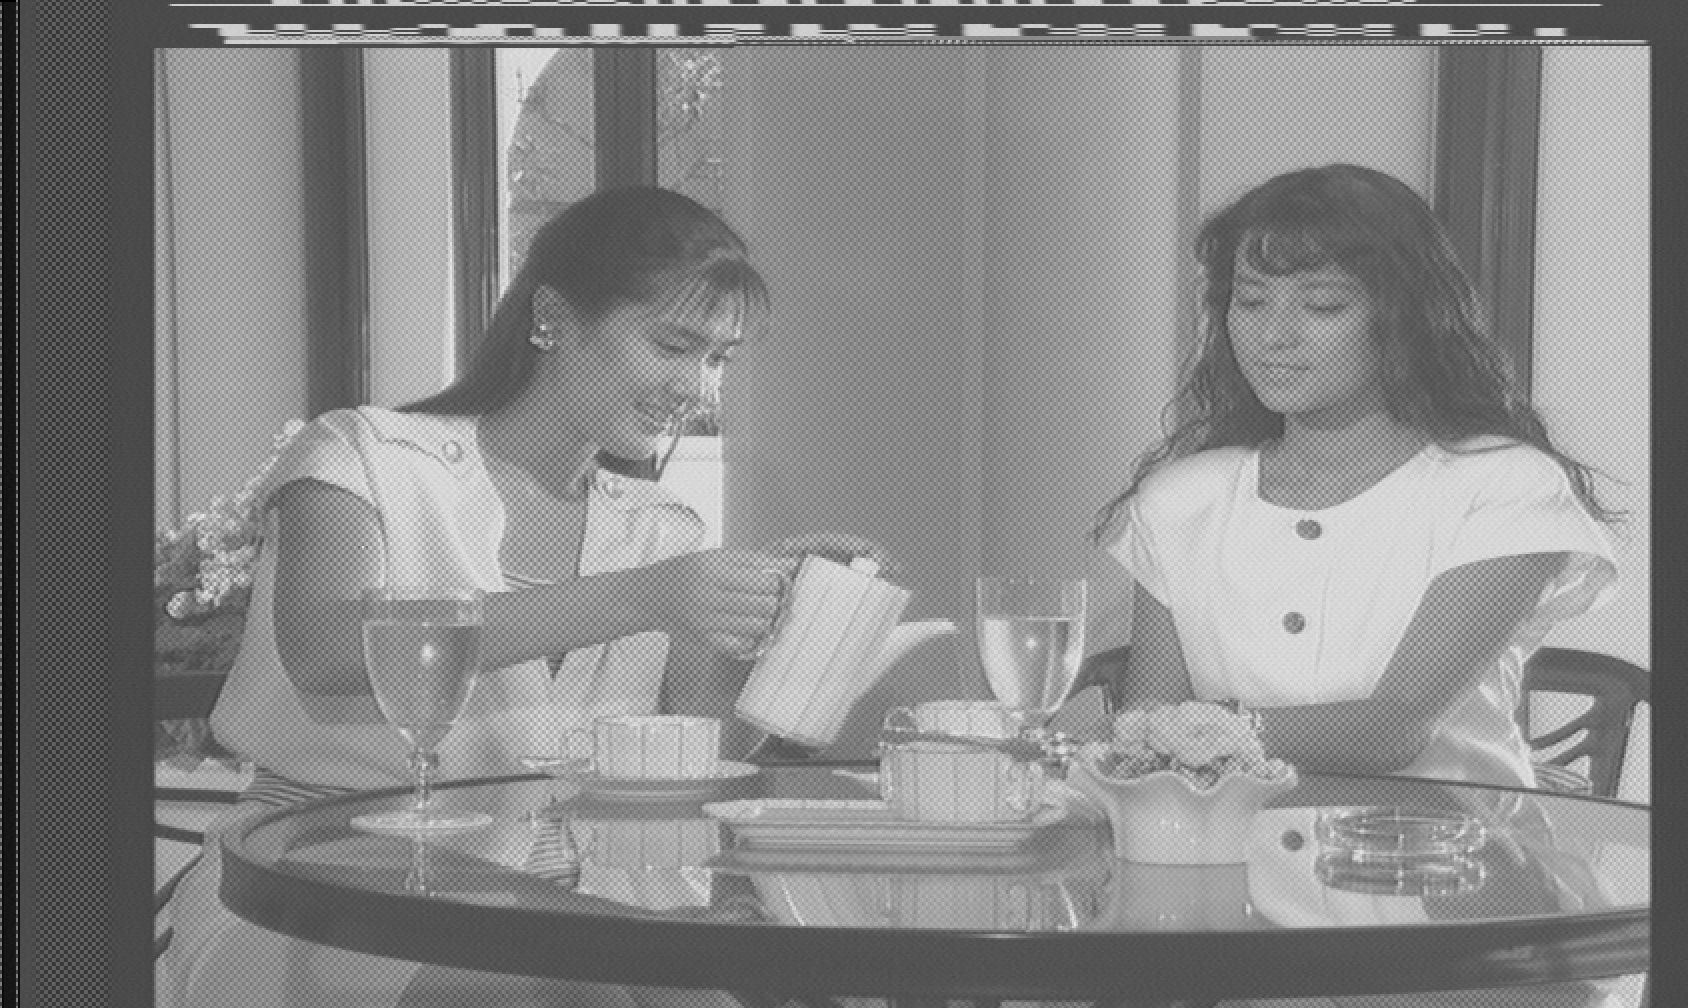

In [45]:
drawdata(output_cropped, 844, 504, hscale=2, vscale=2)

In [151]:
outfile = open('tmp.tbc', 'wb')
outfile.write(output_cropped)

852440

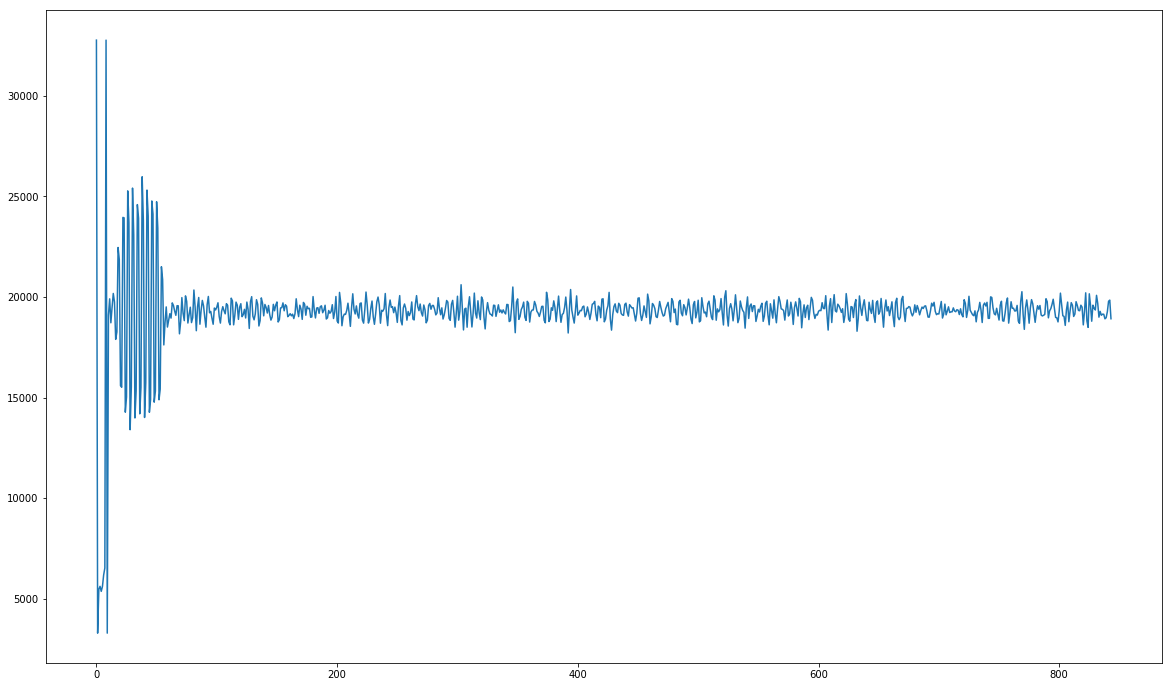

In [155]:
l = 3
plt.plot(output_cropped[l*844:(l + 1) * 844])